In [1]:
from src.skeleton import BaseModel

In [2]:
from src.utils.data_utils import TwoMoonDataset
import torch

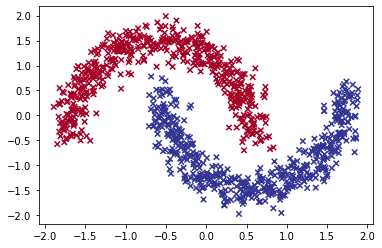

In [3]:
import matplotlib.pyplot as plt
train_dataset = TwoMoonDataset(1000, noise=(0.1,0.1), n_label=1000)
test_dataset = TwoMoonDataset(1000, noise=(0.1,0.1), n_label=1000)
X = train_dataset.X
y = train_dataset.y
M = train_dataset.M

#plt.scatter(X[:,0], X[:,1], c='gray', s=1)
#plt.scatter(X[M][:,0], X[M][:,1], c=y[M], s=30, marker='x', cmap='RdYlBu')
plt.scatter(X[:,0], X[:,1], c=y, s=30, marker='x', cmap='RdYlBu')
plt.show()

In [4]:
print(len(train_dataset), len(test_dataset))

1000 1000


In [5]:
import torch.nn as nn
class MyModel(BaseModel):
    def __init__(self, in_dim, out_dim, model_name='my_model'):
        super().__init__(model_name=model_name)
        self.fc1 = nn.Linear(in_dim, 128)
        self.fc2 = nn.Linear(128, 256)
        self.fc3 = nn.Linear(256, out_dim)
        self.relu = nn.ReLU()
        
    def forward(self, batch, label=None, mask=None):
        x = self.fc1(batch)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        return x
    def criterion(self, pred=None, batch=None, label=None, mask=None):
        return nn.CrossEntropyLoss()(pred, label)
    def compute_score(self, pred=None, batch=None, label=None, mask=None):
        #print('compute_score input : ', pred.shape)
        pred_cls = torch.argmax(pred, dim=1)
        correct = (pred_cls==label).sum()
        return correct / label.shape[0]

In [6]:
BATCH = 256
EPOCH = 10
LR = 1e-2

In [7]:
from torch.utils.data import DataLoader
train_loader = DataLoader(train_dataset, shuffle=True, batch_size=BATCH)
test_loader = DataLoader(test_dataset, batch_size=BATCH)

In [8]:
model = MyModel(2, 2)
model.cuda()

MyModel(
  (fc1): Linear(in_features=2, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=2, bias=True)
  (relu): ReLU()
)

In [9]:
import torch.optim as optim
optimizer = optim.Adam(model.parameters(), LR)

In [10]:
model.train_model(train_loader, test_loader, EPOCH, optimizer)

(0.29s) [Epoch 1]
	Train Loss : 3.8278e-01	Train Score : 8.1300e-01
	Eval Loss : 2.2890e-01	Eval Score : 9.0600e-01
(0.02s) [Epoch 2]
	Train Loss : 2.1169e-01	Train Score : 9.0800e-01
	Eval Loss : 1.4517e-01	Eval Score : 9.3800e-01
(0.02s) [Epoch 3]
	Train Loss : 1.1521e-01	Train Score : 9.5200e-01
	Eval Loss : 7.4258e-02	Eval Score : 9.8400e-01
(0.02s) [Epoch 4]
	Train Loss : 5.9325e-02	Train Score : 9.9300e-01
	Eval Loss : 2.8913e-02	Eval Score : 9.9700e-01
(0.02s) [Epoch 5]
	Train Loss : 2.0384e-02	Train Score : 9.9600e-01
	Eval Loss : 1.0047e-02	Eval Score : 9.9500e-01
(0.02s) [Epoch 6]
	Train Loss : 7.6544e-03	Train Score : 9.9700e-01
	Eval Loss : 4.2196e-03	Eval Score : 9.9900e-01
(0.02s) [Epoch 7]
	Train Loss : 3.2426e-03	Train Score : 1.0000e+00
	Eval Loss : 2.8291e-03	Eval Score : 1.0000e+00
(0.02s) [Epoch 8]
	Train Loss : 2.7238e-03	Train Score : 1.0000e+00
	Eval Loss : 1.5946e-03	Eval Score : 1.0000e+00
(0.02s) [Epoch 9]
	Train Loss : 1.0776e-03	Train Score : 1.0000e+00
	Eva

[Epoch 1]


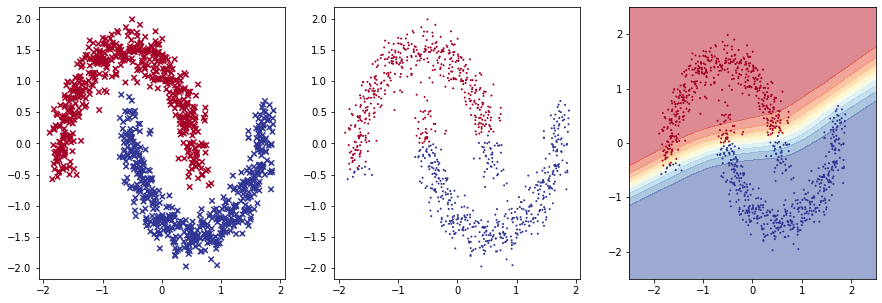

[Epoch 2]


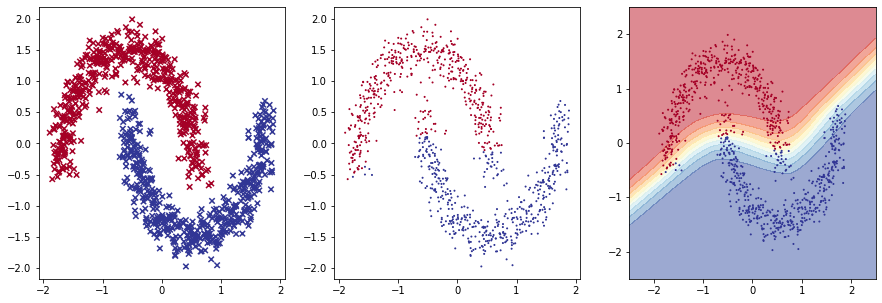

[Epoch 3]


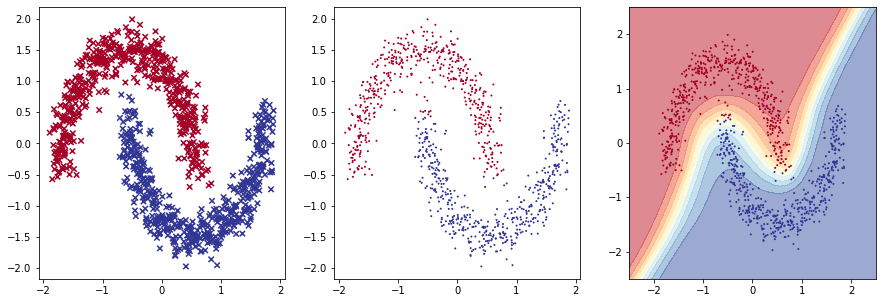

[Epoch 4]


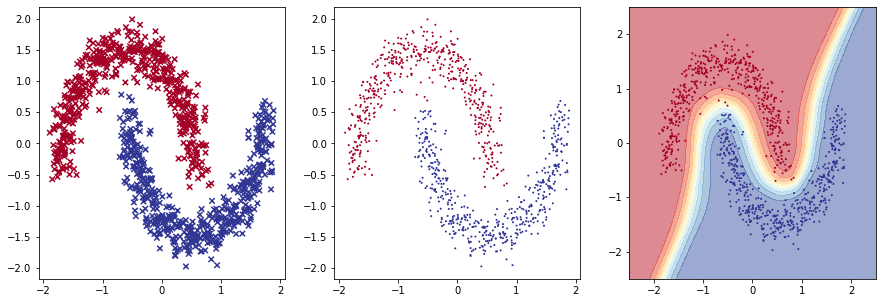

[Epoch 5]


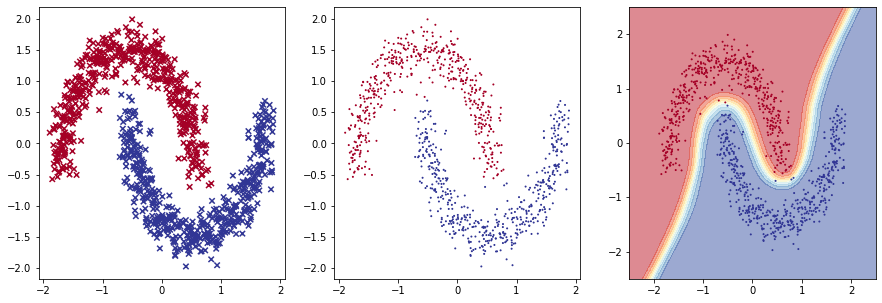

[Epoch 6]


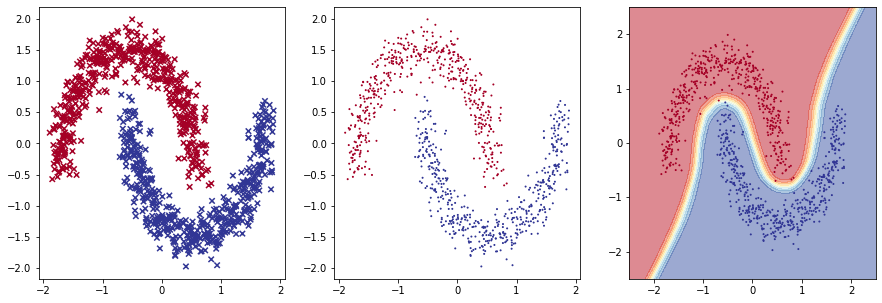

[Epoch 7]


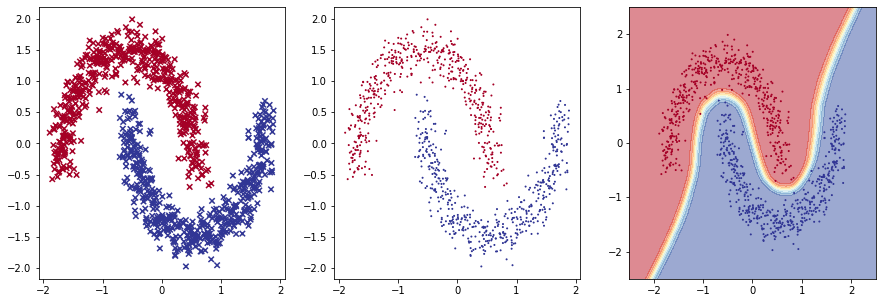

[Epoch 8]


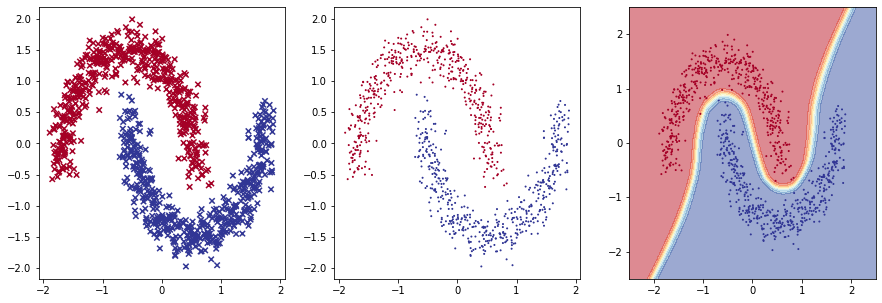

[Epoch 9]


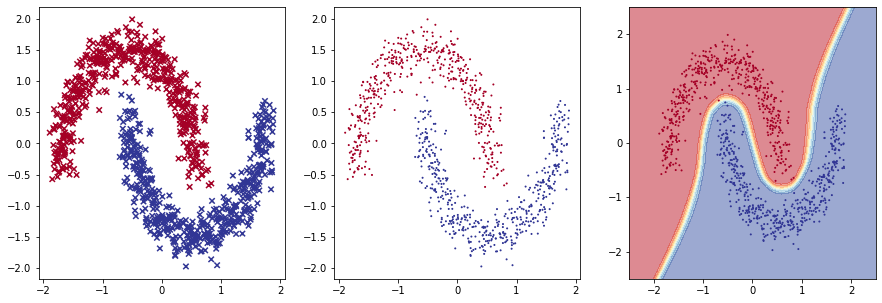

[Epoch 10]


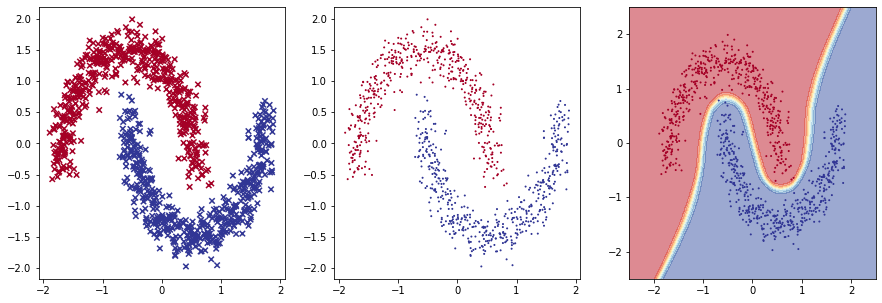

In [11]:
import numpy as np

a=np.linspace(-2.5,2.5,100)
x_grid,y_grid = np.meshgrid(a,a)
x_grid=x_grid.reshape(-1)
y_grid=y_grid.reshape(-1)

grid_dataloader = DataLoader([(torch.tensor([x_grid[i],y_grid[i]]),0,True) for i in range(x_grid.shape[0])], batch_size=BATCH)


for e in range(10):
    model = MyModel(2,2)
    model.load_state_dict(torch.load('./saved_models/my_model_e%d.pth'%(e+1)))
    print('[Epoch %d]'%(e+1))
    model.cuda()
    with torch.no_grad():
        pred=model.predict(test_loader)
        pred_grid=model.predict(grid_dataloader,soft_pred=True)

    X = test_dataset.X
    y = test_dataset.y
    M = test_dataset.M

    fig=plt.figure(figsize=(15,5))
    ax0 = plt.subplot(131)
    ax0.scatter(X[:,0],X[:,1],c='gray',s=1)
    ax0.scatter(X[M][:,0],X[M][:,1],c=y[M],s=30,marker='x',cmap='RdYlBu')

    ax1 = plt.subplot(132)
    ax1.scatter(X[:,0], X[:,1],c=pred,s=1,cmap='RdYlBu')

    ax2 = plt.subplot(133)
    ax2.contourf(x_grid.reshape(100,100), y_grid.reshape(100,100), pred_grid[:,1].reshape(100,100),cmap='RdYlBu',levels=np.linspace(0.0,1.0,11),alpha=0.5)
    ax2.scatter(X[:,0], X[:,1],c=pred,s=1,cmap='RdYlBu')
    plt.show()
